In [1]:
#  patient who's more stablized adolescent #8

# 12/04/2023
# next step: 1) change the policy and value neural network to bound between 0 and 30 2) add eplsilon greedy to explore some actions 3) what's the current initilization?
# 4) do we need to necessarily use network? will a simpler function work easier? -> Mike will take a look

# 12/05/2023
# next step: 1) create a list and start to attach mean & std value to it. i want to see that if the patient is in the range of 100 to 120 let's say, as we train
# our model, the mean is going from 28 to 1 for instance.





In [2]:
# pip install simglucose


In [3]:
# pip install wandb


In [4]:
import torch

from collections import deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import gym

In [5]:
# import wandb
# wandb.login()
# run=wandb.init()

In [6]:


# class Policy(object):

#     def __init__(self, obssize, lr):

class Policy(torch.nn.Module):

    def __init__(self, obssize, lr):

        super(Policy, self).__init__()

        """
        obssize: size of the states
        """
        # Define the model
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(obssize, 256),
                    torch.nn.ReLU(),
                    torch.nn.Linear(256, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 64),
                    torch.nn.ReLU(),
                    torch.nn.Linear(64, 32),
                    torch.nn.ReLU(),
                    torch.nn.Linear(32, 1), # Outputs mean of the action
                    torch.nn.Sigmoid()  # Add sigmoid activation function to constrain in the range of (0,1)
                )


        # Custom weight and bias initialization for the final layer
        torch.nn.init.zeros_(self.model[-2].weight)
        bias_value = np.log(0.0167 / (1 - 0.0167))  # Approximate value for sigmoid output of 0.0167
        torch.nn.init.constant_(self.model[-2].bias, bias_value)


        # Scale the output to match the range of 0 to 30
        self.action_scale = 30

        # Standard deviation for the action distribution
        # self.log_std = torch.nn.Parameter(torch.zeros(0))
        self.log_std = torch.nn.Parameter(torch.tensor([-18.0]))

        # Define the optimizer
        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.optimizer = torch.optim.Adam(list(self.model.parameters()) + [self.log_std], lr=lr)


        # Record hyper-parameters
        self.obssize = obssize

    def compute_action(self, state, bg_last_hour):
        """
        Compute action for given state
        state: numpy array of size [obssize]
        return: action as a numpy array
        """

        # Extract BG levels from the last hour and combine with current state
        bg_last_hour_values = np.array([obs.CGM for obs in bg_last_hour])
        combined_state = np.append(bg_last_hour_values, state)

        combined_state_tensor = torch.FloatTensor(combined_state)
        mean = self.model(combined_state_tensor) * self.action_scale

        # state = torch.FloatTensor(state)
        # mean = self.model(state) * self.action_scale

        std = torch.exp(self.log_std)  # Standard deviation

        # print("The current state is ", state)
        # print("When computing the action, mean is ", mean)
        # print("When computing the action, std is ", std)

        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        # Clip the action to be within the range of 0 to 30
        action = np.clip(action, 0, 30)

        # Detach the action tensor from the computation graph
        action = action.detach().cpu().numpy()

        return action, mean, std

    def train(self, states, actions, Qs):
        """
        states: numpy array (states)
        actions: numpy array (actions)
        Qs: numpy array (Q values)
        """
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        Qs = torch.FloatTensor(Qs)

        # Compute mean
        means = self.model(states) * self.action_scale
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(means, std)

        # Compute log probability of the actions taken
        log_probs = dist.log_prob(actions).sum(-1)

        # Calculate loss
        loss = -(log_probs * Qs).mean()

        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()

        # Print gradients
        # self.print_gradients()

        # Update
        self.optimizer.step()

        return loss.detach().cpu().data.numpy()


    def print_gradients(self):
          """
          Print the gradients of all parameters in the policy network
          """
          for name, param in self.model.named_parameters():
              if param.grad is not None:
                  print(f'Gradient of {name}: {param.grad.data}')
              else:
                  print(f'Gradient of {name} is None')

In [7]:

class ValueFunction(torch.nn.Module):
    def __init__(self, obssize, lr):
        """
        obssize: size of the state space
        lr: learning rate
        """
        super(ValueFunction, self).__init__()
        # # Define the model
        # self.model = torch.nn.Sequential(
        #     torch.nn.Linear(obssize, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 32),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(32, 1)  # Output a single value
        # )

        self.model = torch.nn.Sequential(
                    torch.nn.Linear(obssize, 256),
                    torch.nn.ReLU(),
                    torch.nn.Linear(256, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 64),
                    torch.nn.ReLU(),
                    torch.nn.Linear(64, 32),
                    torch.nn.ReLU(),
                    torch.nn.Linear(32, 1), # Output a single value
                )

        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def compute_values(self, states):
        """
        Compute value function for given states
        states: numpy array of size [numsamples, obssize]
        return: numpy array of size [numsamples]
        """
        states = torch.FloatTensor(states)
        return self.model(states).cpu().data.numpy()

    def train(self, states, targets):
        """
        Train the value function network
        states: numpy array of states
        targets: numpy array of target values
        """
        states = torch.FloatTensor(states)
        targets = torch.FloatTensor(targets)

        # Compute value predictions for states
        v_preds = self.model(states).squeeze()

        # Calculate loss as Mean Squared Error
        loss = torch.nn.functional.mse_loss(v_preds, targets)

        # Backward pass and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [8]:
import warnings
# Ignore FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [9]:
# Define the discounted rewards function
def discounted_rewards(r, gamma):
    """Compute discounted rewards."""
    discounted_r = np.zeros_like(r)
    running_sum = 0
    for i in reversed(range(0, len(r))):
        running_sum = running_sum * gamma + r[i]
        discounted_r[i] = running_sum
    return list(discounted_r)

In [10]:

# def custom_reward(BG_last_hour):
#     if BG_last_hour[-1] > 180:
#         return -1
#     elif BG_last_hour[-1] < 70:
#         return -2
#     else:
#         return 1

# def custom_reward(BG_last_hour):
#     print("BG_last_hour is ", BG_last_hour)
#     if 70 <= BG_last_hour[-1] <= 180:
#         return 1
#     elif (54 <= BG_last_hour[-1] < 70) or (180 < BG_last_hour[-1] <= 199):
#         return 0
#     elif (40 <= BG_last_hour[-1] < 54) or (200 < BG_last_hour[-1]):
#         return -100
#     else:
#         return -10000

# def custom_reward(BG_last_hour):
#    bg_current=BG_last_hour[-1]
#    if bg_current >= 70 and bg_current <= 180:
#       reward = 1
#    else:
#       reward = 0

#    return reward


def custom_reward(BG_last_hour):
   bg_current=BG_last_hour[-1]
   if bg_current >= 70 and bg_current <= 180:
      reward = 0.5
   elif bg_current > 180 and bg_current <= 300:
      reward = -0.8
   elif bg_current > 300 and bg_current <= 350:
      reward = -1
   elif bg_current >= 30 and bg_current < 70:
      reward = -1.5
   else:
      reward = -2
   return reward



In [11]:
%%time
# %%wandb

# Initialize Weights & Biases
# wandb.init(project="diabetes_policy_gradient")  # Uncomment this line if you're using Weights & Biases

import random

import time
starting_time = time.time()

# Define parameters
alpha = 1e-3  # Learning rate for policy gradient
beta = 1e-3  # Learning rate for baseline
numtrajs = 5  # Number of trajectories per iteration
iterations = 1000  # Total number of iterations
gamma = .999  # Discount factor
max_steps = 480 * 3 # simulation of 3 days of one patinet

# # Initial Epsilon Value
# epsilon = 0.1
# # Minimum Epsilon Value
# min_epsilon = 0.01
# # Decay Rate or Factor (this example uses a simple linear decay)
# epsilon_decay = 0.001

# Define parameters
epsilon = 0.9  # Start with a high exploration rate
epsilon_end = 0.01   # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for each episode

# Initialize the environment
from gym.envs.registration import register
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
start_time = datetime(2018, 1, 1, 0, 0, 0)
random_scenario = RandomScenario(start_time=start_time, seed=1)
meal_scenario = CustomScenario(start_time=start_time, scenario=[(1,20)])


register(
    id='simglucose-child8-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'child#008',
            'custom_scenario': random_scenario,
            'reward_fun': custom_reward}
)

env = gym.make('simglucose-child8-v0')

observation = env.reset()
print(observation)

obssize = env.observation_space.shape[0] + 20  # Assuming state is a scalar + BG history of length 20
actsize = 1  # Action is a scalar

# Initialize networks
actor = Policy(obssize, alpha)
baseline = ValueFunction(obssize, beta)
# baseline = ValueFunction(1, beta)


# Record training rewards
rrecord = []
MA = []

# Main training loop
for ite in range(iterations):

    # env.render(mode='human')

    print("*** Running Iteration ***", ite)

    OBS, ACTS, ADS, VAL = [], [], [], []

    for nt in range(numtrajs):
        obss, acts, rews, means, stds = [], [], [], [], []
        obs = env.reset()
        done = False
        bg_last_hour = [obs for i in range(20)]

        i = 0
        while not done and i < max_steps:
            i += 1

            if np.random.rand() < epsilon:
              # Generate a random number between 0 and 30
              action = np.array([random.uniform(0, 5)])
            else:
              # Compute action using the policy
              action, mean, std = actor.compute_action(obs, bg_last_hour)

              means.append(mean)
              stds.append(std)

            next_obs, reward, done, _ = env.step(action)

            # Update BG_history with the new observation
            bg_last_hour.append(next_obs)
            if len(bg_last_hour) > 20:
                bg_last_hour.pop(0)

            # Record observations, actions, and rewards

            combined_state = np.append([obs.CGM for obs in bg_last_hour], obs)
            obss.append(combined_state)  # Store the combined state
            acts.append(action)
            rews.append(reward)


            # print("action is", action)
            # print("action type is ", type(action))

            obs = next_obs

        print("finish trajectory #", nt)
        print("survived ", i, " periods")

        # Log training performance

        # if the simulation ends, it means patient in dangerous condition, give -100 reward to the last step.
        if done:
          rews[-1] = -100
        rrecord.append(np.sum(rews))

        # Compute discounted rewards
        V_hat = discounted_rewards(rews, gamma)
        # print("V_hat is", V_hat)

        # Record for batch update
        VAL.extend(V_hat)
        OBS.extend(obss)
        ACTS.extend(acts)

    # epsilon = max(min_epsilon, epsilon - epsilon_decay)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Convert lists to numpy arrays for training
    OBS_np = np.array(OBS)
    VAL_np = np.array(VAL)
    ACTS_np = np.array(ACTS)

    print("mean: ", means)
    print("std: ", stds)

    # print("In this episode, mean is ", means[0])
    # print("In this episode, std is ", stds[0])

    print('OBS:', OBS_np)
    print('ACTS:', ACTS_np)
    print('VAL:', VAL_np)

    # Train baseline and compute baselines
    baseline.train(OBS_np, VAL_np)
    baseline_values = baseline.compute_values(OBS_np)

    # Compute advantages and update the policy
    ADS = VAL_np - baseline_values
    actor.train(OBS_np, ACTS_np, ADS)

    # Moving average for visualization
    fixedWindow = 100
    movingAverage = np.mean(rrecord[-fixedWindow:]) if len(rrecord) >= fixedWindow else np.mean(rrecord)
    MA.append(movingAverage)
    # Log data
    # wandb.log({"training reward": rrecord[-1], "training reward moving average": movingAverage})

# Close the environment
# env.close()

# End the timer

ending_time = time.time()

# Calculate the duration
duration = ending_time - starting_time
print(f"The code block took {duration} seconds to run.")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Streaming output truncated to the last 5000 lines.
 [8.71592043e-09]
 [9.05170550e-10]
 [0.00000000e+00]
 [4.62311744e-09]
 [7.44244977e-09]
 [3.23135807e-09]
 [0.00000000e+00]
 [1.00548325e-08]
 [0.00000000e+00]
 [1.99325711e-08]
 [3.44134570e-08]
 [5.15625898e-09]
 [8.84787799e-09]
 [5.48888890e-09]
 [1.79978983e-08]
 [1.84043660e-08]
 [0.00000000e+00]
 [7.50619744e-09]
 [1.79693718e-08]
 [2.80135914e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.92509969e-09]
 [1.47714463e-09]
 [0.00000000e+00]
 [2.51477843e-08]
 [4.40641035e-09]
 [2.08842170e-08]
 [0.00000000e+00]
 [8.28534752e-09]
 [1.89600637e-08]
 [0.00000000e+00]
 [1.04622142e-08]
 [2.46905323e-08]
 [0.00000000e+00]
 [1.10570317e-08]
 [0.00000000e+00]
 [8.52219628e-09]
 [1.14363150e-08]
 [2.93414377e-08]
 [0.00000000e+00]
 [5.84628612e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.70324835e-10]
 [1.55943098e-08]
 [1.99380468e-09]
 [0.00000000e+00]
 [0.00000000e

In [12]:
MA

[-108.6,
 -108.0,
 -107.2,
 -107.125,
 -107.46,
 -107.73333333333333,
 -107.78571428571429,
 -107.8875,
 -108.12222222222222,
 -108.24,
 -108.23636363636363,
 -108.36666666666666,
 -108.36153846153846,
 -108.17857142857143,
 -108.04,
 -108.0125,
 -108.12941176470588,
 -108.21666666666667,
 -108.26842105263158,
 -108.36,
 -108.45,
 -108.405,
 -108.625,
 -108.755,
 -108.76,
 -108.81,
 -108.855,
 -108.87,
 -108.775,
 -108.81,
 -108.564,
 -108.444,
 -108.51899999999999,
 -108.73100000000001,
 -108.766,
 -108.881,
 -108.796,
 -108.641,
 -108.47,
 -108.38,
 -108.11,
 -108.17,
 -108.1,
 -107.905,
 -107.98,
 -107.83,
 -107.975,
 -108.055,
 -108.2,
 -108.11,
 -108.296,
 -108.306,
 -108.02999999999999,
 -107.988,
 -108.14299999999999,
 -107.97399999999999,
 -108.039,
 -108.184,
 -108.475,
 -108.41,
 -108.52,
 -108.705,
 -108.63,
 -108.765,
 -108.77,
 -108.945,
 -108.757,
 -108.637,
 -108.58,
 -108.625,
 -108.655,
 -108.675,
 -108.85600000000001,
 -108.988,
 -109.133,
 -109.072,
 -109.257,
 -109.

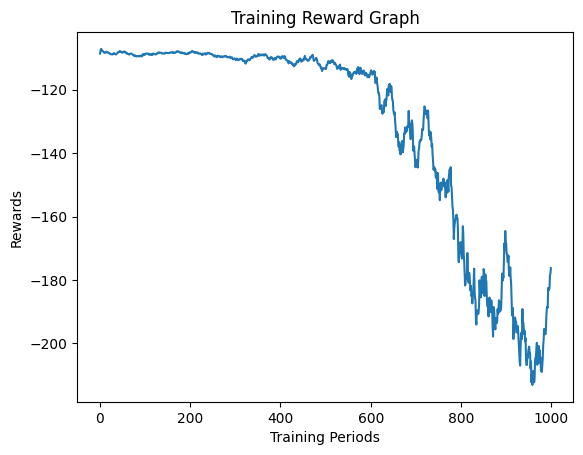

In [13]:
import matplotlib.pyplot as plt

# Generating a list of indices for the x-axis
x = range(len(MA))

# Creating the plot
plt.plot(x, MA)

# Adding labels and title (optional)
plt.xlabel('Training Periods')
plt.ylabel('Rewards')
plt.title('Training Reward Graph')

# Displaying the plot
plt.show()

In [14]:
# This chuck of code is to save the trained RL model on colab drive

from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/RL_Final/RL_child_exp_policy_model.pth'
torch.save(actor.state_dict(), model_save_path)


MessageError: ignored

In [8]:
import torch

from collections import deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import gym


In [9]:
import warnings
# Ignore FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [10]:
from google.colab import drive

drive.mount('/content/drive')

obssize = 1 + 20 # 20 BG levels in the past hour
alpha = 1e-3  # Learning rate for policy gradient

actor = Policy(obssize, alpha)  # Replace with the actual values used

actor.load_state_dict(torch.load('/content/drive/My Drive/RL_Final/RL_child_exp_policy_model.pth'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming your trained policy is loaded into a variable named 'trained_policy'
# # and 'compute_action' expects a single value as input

# blood_glucose_levels = np.arange(39, 1001)  # 39 to 1000
# insulin_doses = []

# for level in blood_glucose_levels:
#     # You might need to adjust this depending on how compute_action expects the input
#     action, _, _ = actor.compute_action(np.array([level]))
#     insulin_doses.append(action[0])  # Assuming action is returned as a single-element array

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(blood_glucose_levels, insulin_doses)
# # plt.scatter(blood_glucose_levels, insulin_doses, alpha=0.6)  # using scatter plot here
# plt.xlabel('Blood Glucose Level')
# plt.ylabel('Insulin Dose')
# plt.title('Child: Insulin Dose vs Blood Glucose Level')
# plt.show()

In [12]:
# see the change of blood sugar level with the insulin pump
# have a list also recording the survival periods in each trajectory


In [13]:

# Initialize the environment
from gym.envs.registration import register
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
start_time = datetime(2018, 1, 1, 0, 0, 0)
random_scenario = RandomScenario(start_time=start_time, seed=1)
meal_scenario = CustomScenario(start_time=start_time, scenario=[(1,20)])


In [15]:

### Evaluation
def evaluate(policy, env, episodes, eval_name):
    # main iteration
    score = 0
    eval_r = []
    survive = []

    OBS, ACTS, MEANS, STDS, REWS, MEAL, RISK, TIME = [], [], [], [], [], [], [], []

    for episode in range(episodes):
        env.render(mode='human')

        obss, acts, rews, means, stds, meal, risk, time = [], [], [], [], [], [], [], []

        obs = env.reset()
        done = False
        rsum = 0
        sur = 0
        bg_last_hour = [obs for i in range(20)]

        print("the initial bg_last_hour is ", bg_last_hour)


        while not done and sur < 480 * 3:

            # Compute action using the policy
            action, mean, std = actor.compute_action(obs, bg_last_hour)
            next_obs, r, done, info = env.step(action)

            # Update BG_history with the new observation
            bg_last_hour.append(next_obs)
            if len(bg_last_hour) > 20:
                bg_last_hour.pop(0)

            means.append(mean)
            stds.append(std)
            obss.append(obs)
            acts.append(action)
            rews.append(r)

            # print("meal is", info['meal'])
            # print("risk if", info['risk'])
            # print("time is", info['time'])

            # for graph need
            meal.append(info['meal'])
            risk.append(info['risk'])
            time.append(info['time'])

            # update data
            rsum += r
            obs = next_obs
            sur += 1

        if done:
          eval_r.append(rsum)
          rsum -= 100
        else:
          eval_r.append(rsum)

        # print("The last hour blood sugar is ", obss[-20:])
        # print("The last hour insulin units is ", acts[-20:])
        # print("Total measl aten", sum(meal))
        # print("The last hour meal vector is", meal[:-20])
        # print("The hour time is", time[:-20])
        # print("The last hour risk is", risk[:-20])

        survive.append(sur)
        print("survived ", sur)

        # wandb.log({"eval reward" : rsum})
        score +=rsum

        OBS.append(obss)
        ACTS.append(acts)
        MEANS.append(means)
        STDS.append(stds)
        REWS.append(rews)

        MEAL.append(meal)
        RISK.append(risk)
        TIME.append(time)

        # print("the acts are ", ACTS)
        print("the last two hour CGM are ", obss[-40:])

    generate_graphs(TIME, OBS, MEAL, ACTS, RISK, eval_name)

    score = score/episodes

    # print(eval_r)
    # print(survive)
    # print("type of eval r ", type(eval_r))
    # print("type of survive ", type(survive))

    print("The percentage of time in the 70-180 healthy range is ", np.mean([(r / s) * 100 for r, s in zip(eval_r, survive)]))

    return score, eval_r, survive

In [16]:
# for the graphing function, i want to have bg, meal, insulin, risk
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os

# Folder path in Google Drive
folder_path = '/content/drive/My Drive/RL_Final/Child_exp_graph'

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

def generate_graphs(time_data, cgm_data, meal_data, insulin_data, risk_data, eval_name):
    for index in range(len(time_data)):
        # Define the figure size and layout
        fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

        # ... [Rest of the plotting code as before] ...

        # Format the x-axis to show time in HH:MM format
        myFmt = DateFormatter('%H:%M')

        # CGM data subplot
        axs[0].xaxis.set_major_formatter(myFmt)
        axs[0].plot(time_data[index], [obs.CGM for obs in cgm_data[index]], label='CGM')
        axs[0].set_ylabel('BG (mg/dL)')
        axs[0].set_ylim(0, 350)  # Set y-axis limit for BG
        axs[0].legend(loc='upper right')
        # axs[0].grid(True)

        # Meal data subplot
        axs[1].xaxis.set_major_formatter(myFmt)
        axs[1].plot(time_data[index], meal_data[index], label='CHO', color='navy')
        axs[1].set_ylabel('CHO (g)')
        axs[1].set_ylim(0, 70)  # Set y-axis limit for CHO
        axs[1].legend(loc='upper right')
        # axs[1].grid(True)

        # Insulin data subplot
        insulin_values = [act[0] for act in insulin_data[index]]
        axs[2].xaxis.set_major_formatter(myFmt)
        axs[2].plot(time_data[index], insulin_values, label='Insulin', color='darkgreen')
        axs[2].set_ylabel('Insulin (Units)')
        axs[2].set_ylim(0, 1)  # Set y-axis limit for insulin
        axs[2].legend(loc='upper right')
        # axs[2].grid(True)

        # Risk data subplot
        axs[3].xaxis.set_major_formatter(myFmt)
        axs[3].plot(time_data[index], risk_data[index], label='Risk Index', color='maroon')
        axs[3].set_ylabel('Risk Index')
        axs[3].set_xlabel('Time')
        axs[3].set_ylim(0, 120)  # Set y-axis limit for risk index
        axs[3].legend(loc='upper right')
        # axs[3].grid(True)

        # Add a title to each graph
        plt.suptitle(f'Simulation #{index + 1}')

        # Adjust the layout
        plt.tight_layout()


        # Generate a file path
        file_name = f'{eval_name}_simulation_{index + 1}.png'
        file_path = os.path.join(folder_path, file_name)

        # Save the figure to the Google Drive folder
        plt.savefig(file_path)

        # Show the plot
        plt.show()

        # Close the figure after saving to free up memory
        plt.close(fig)


In [17]:
# after training, we will evaluate the performance of the learned policy "actor"
# on a target environment
register(
    id='simglucose-child8-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'child#008',
            'custom_scenario': random_scenario,
            'reward_fun': custom_reward}
)

eval_episodes = 5
env_test = gym.make('simglucose-child8-v0')
score, eval_r, survive = evaluate(actor, env_test, eval_episodes, "child8")
# wandb.run.summary["score"]=score
print("eval performance of the learned policy: {}".format(score))
print("survival periods of the each simulated episode: {}".format(survive))

Error: ignored

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


the initial bg_last_hour is  [Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025), Observation(CGM=150.74605268301025)]
survived  183
the last two hour CGM are  [Observation(CGM=447.2243277587878), Observation(CGM=451.27357880788065), Observation(CGM=455.6010081132613), Observation(CGM=460.1699157890763), Observation(CGM=464.94360671818447), Observ

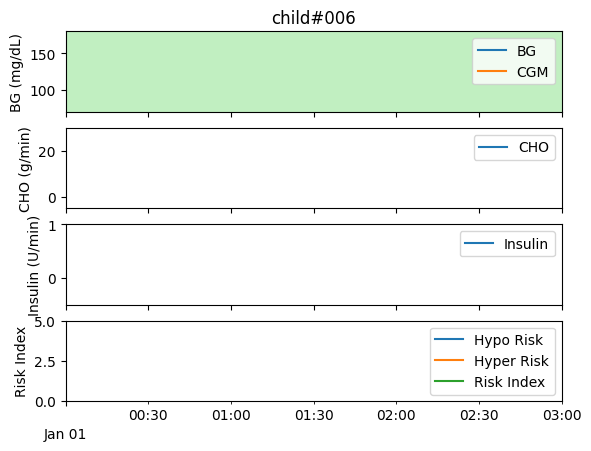

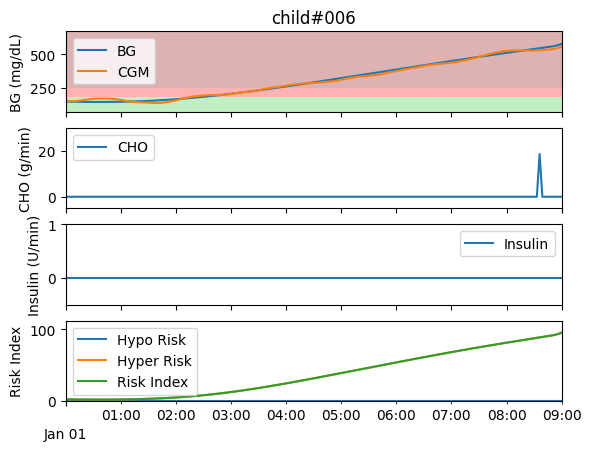

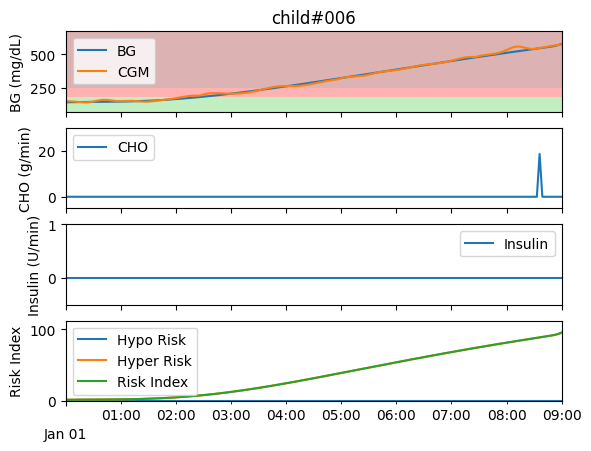

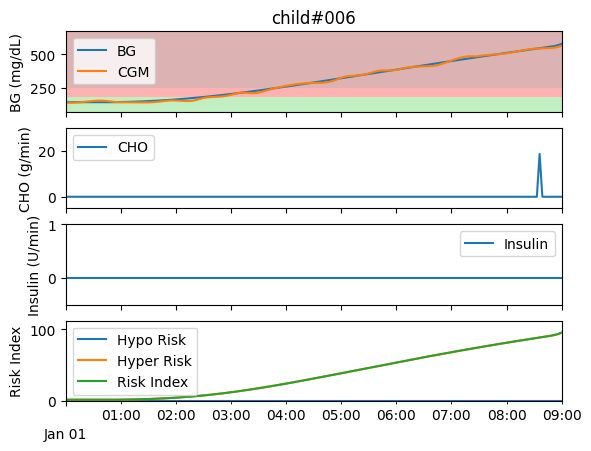

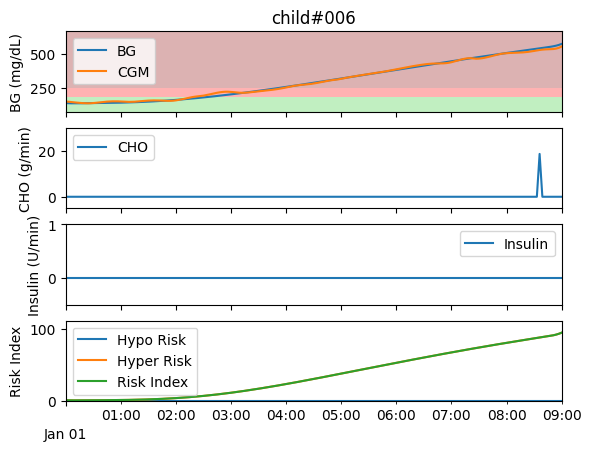

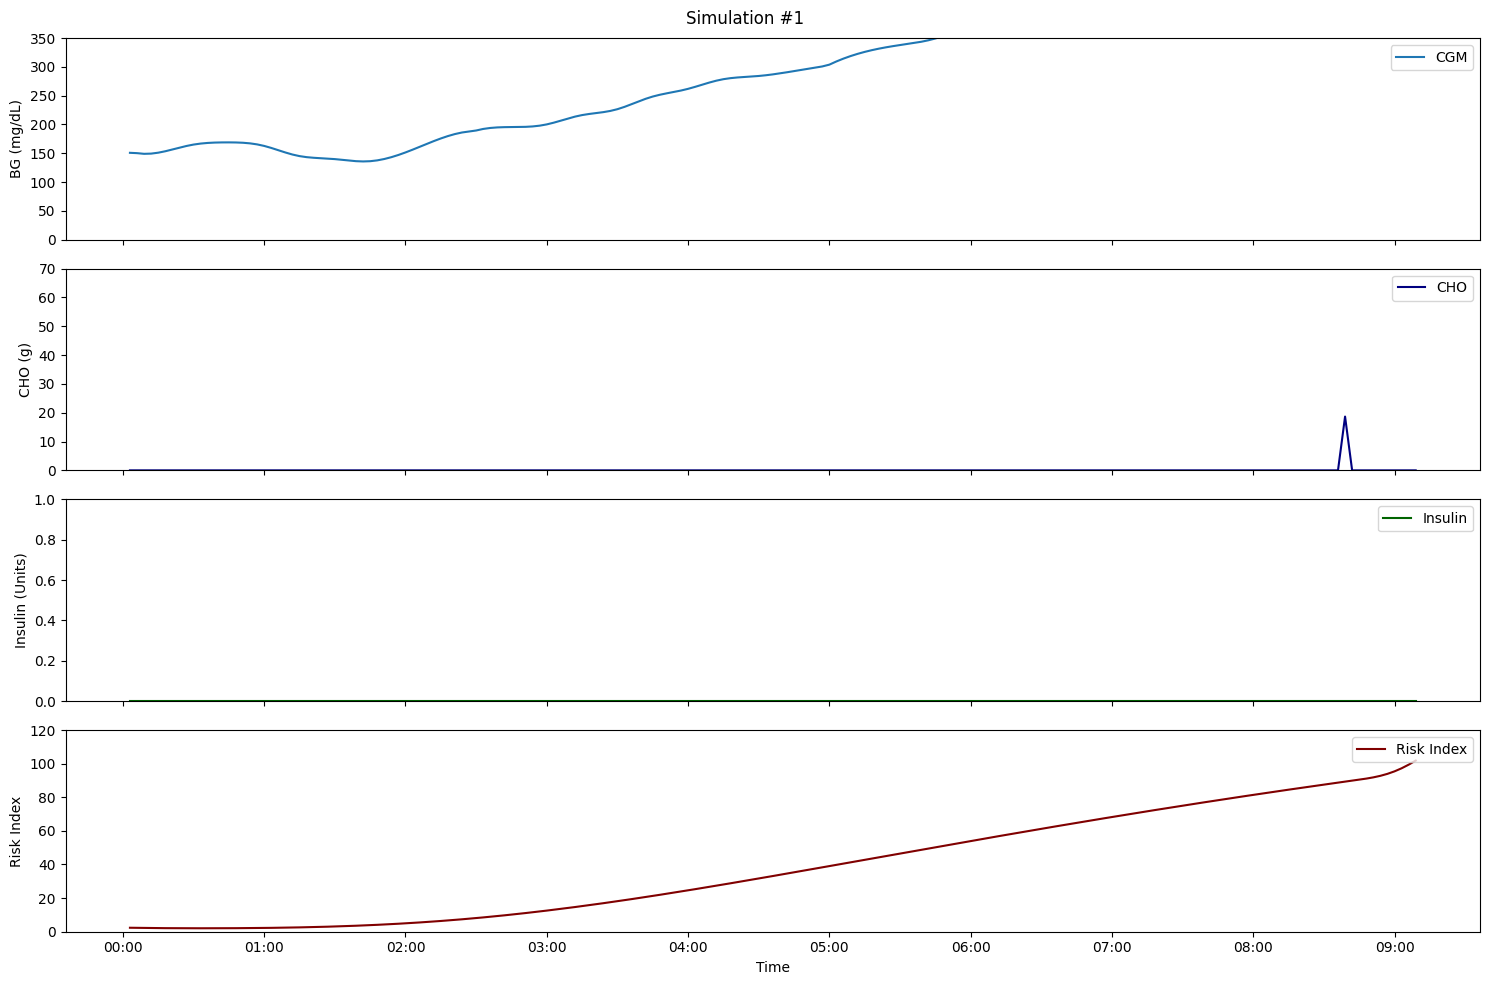

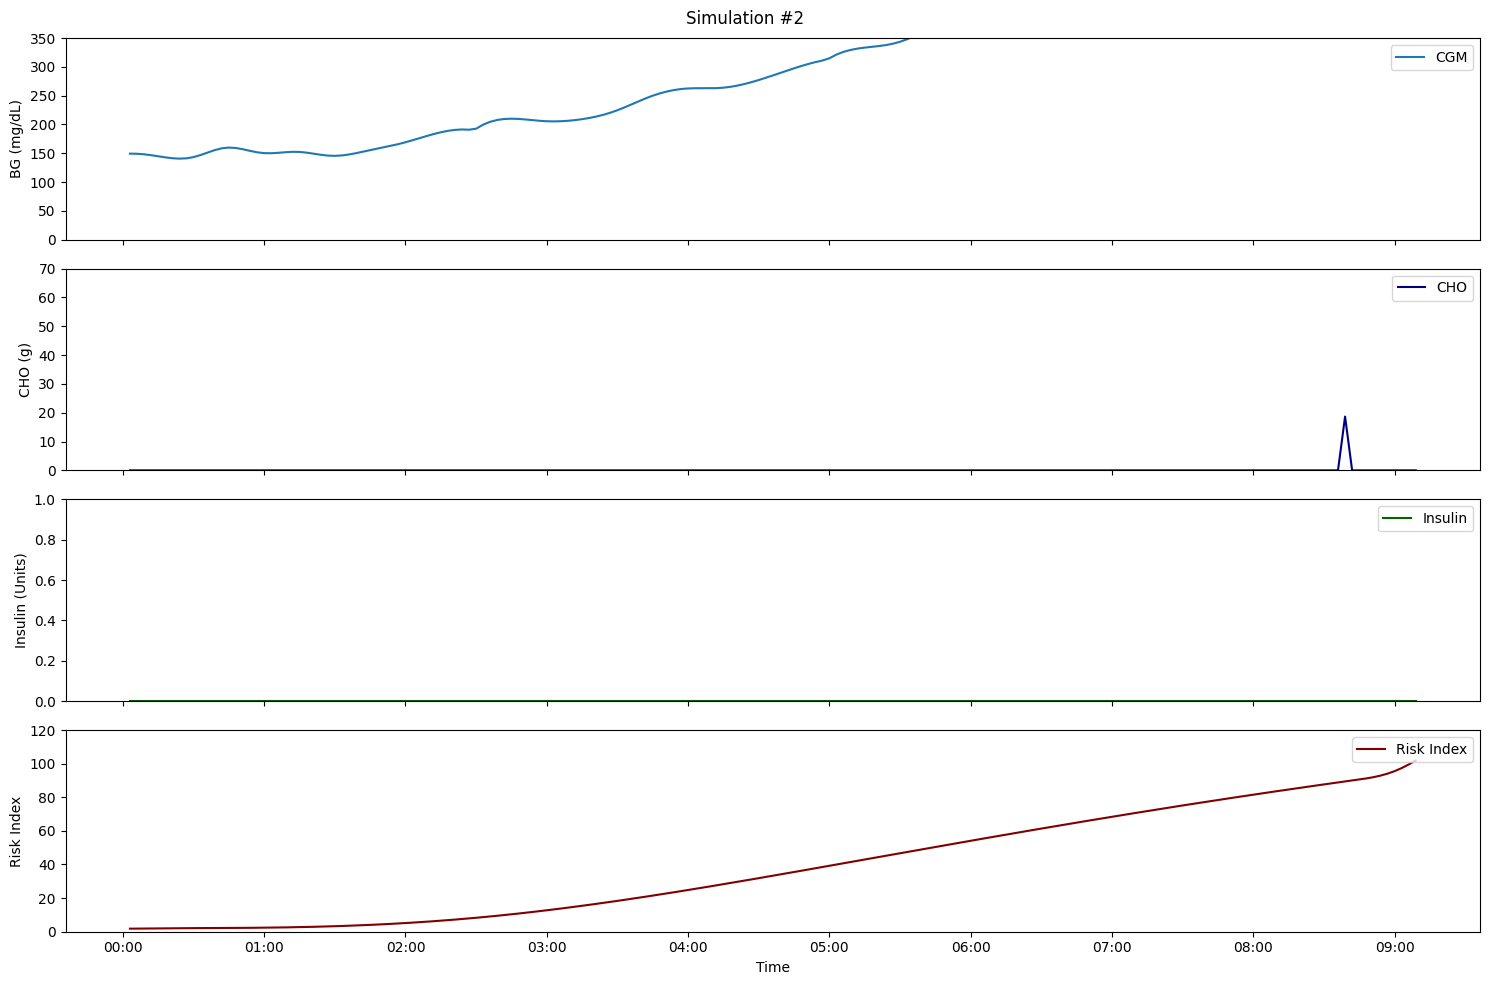

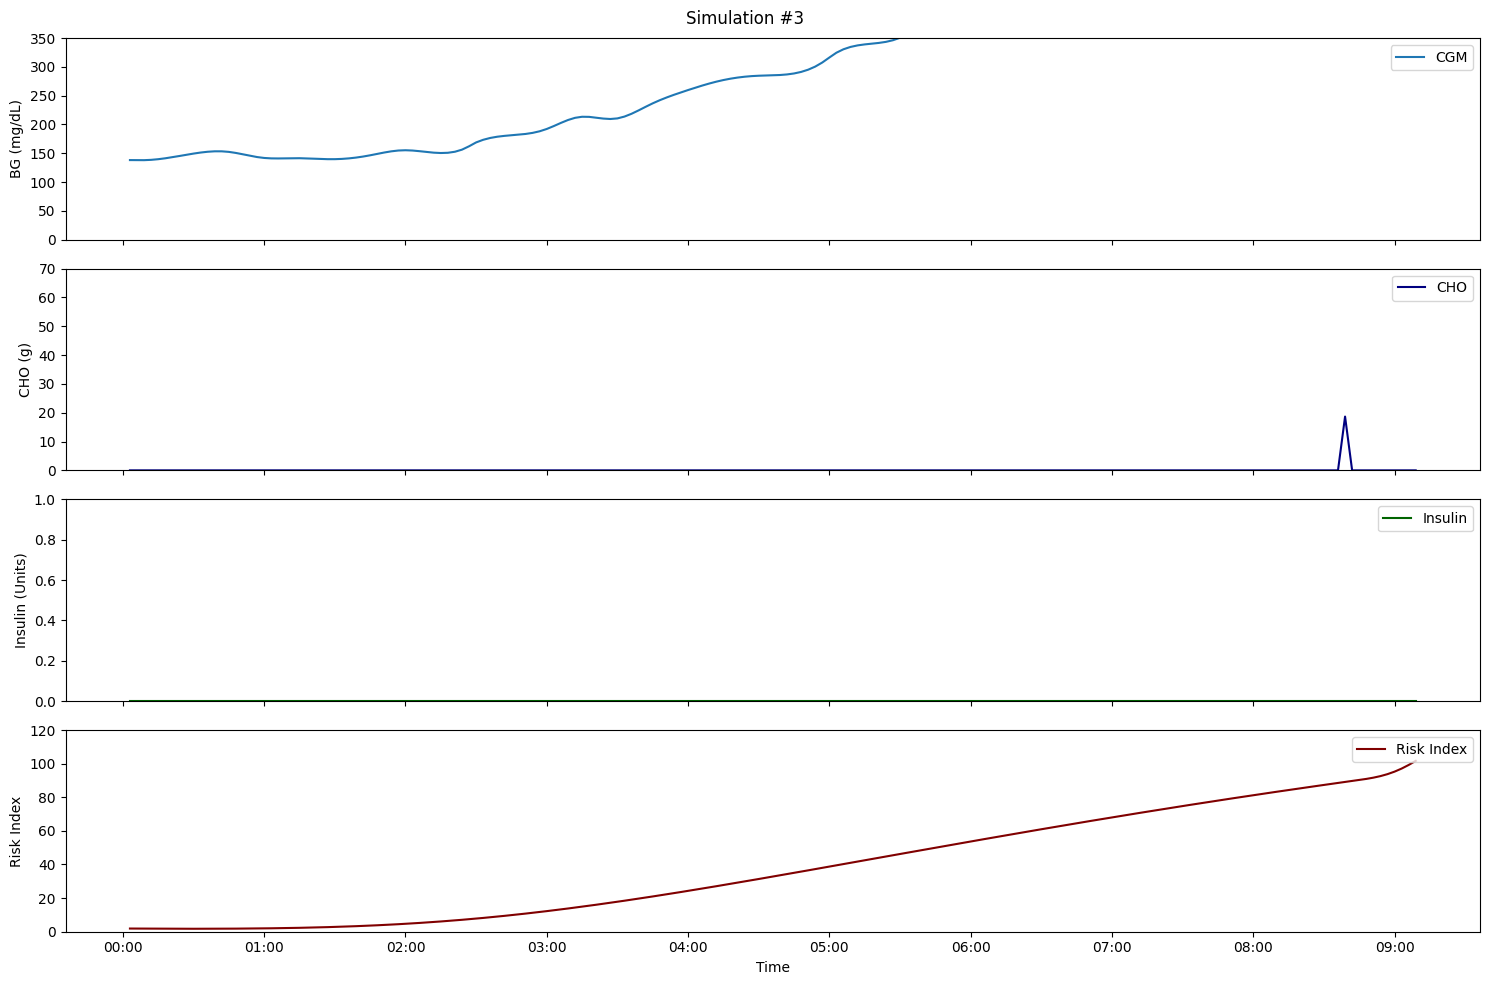

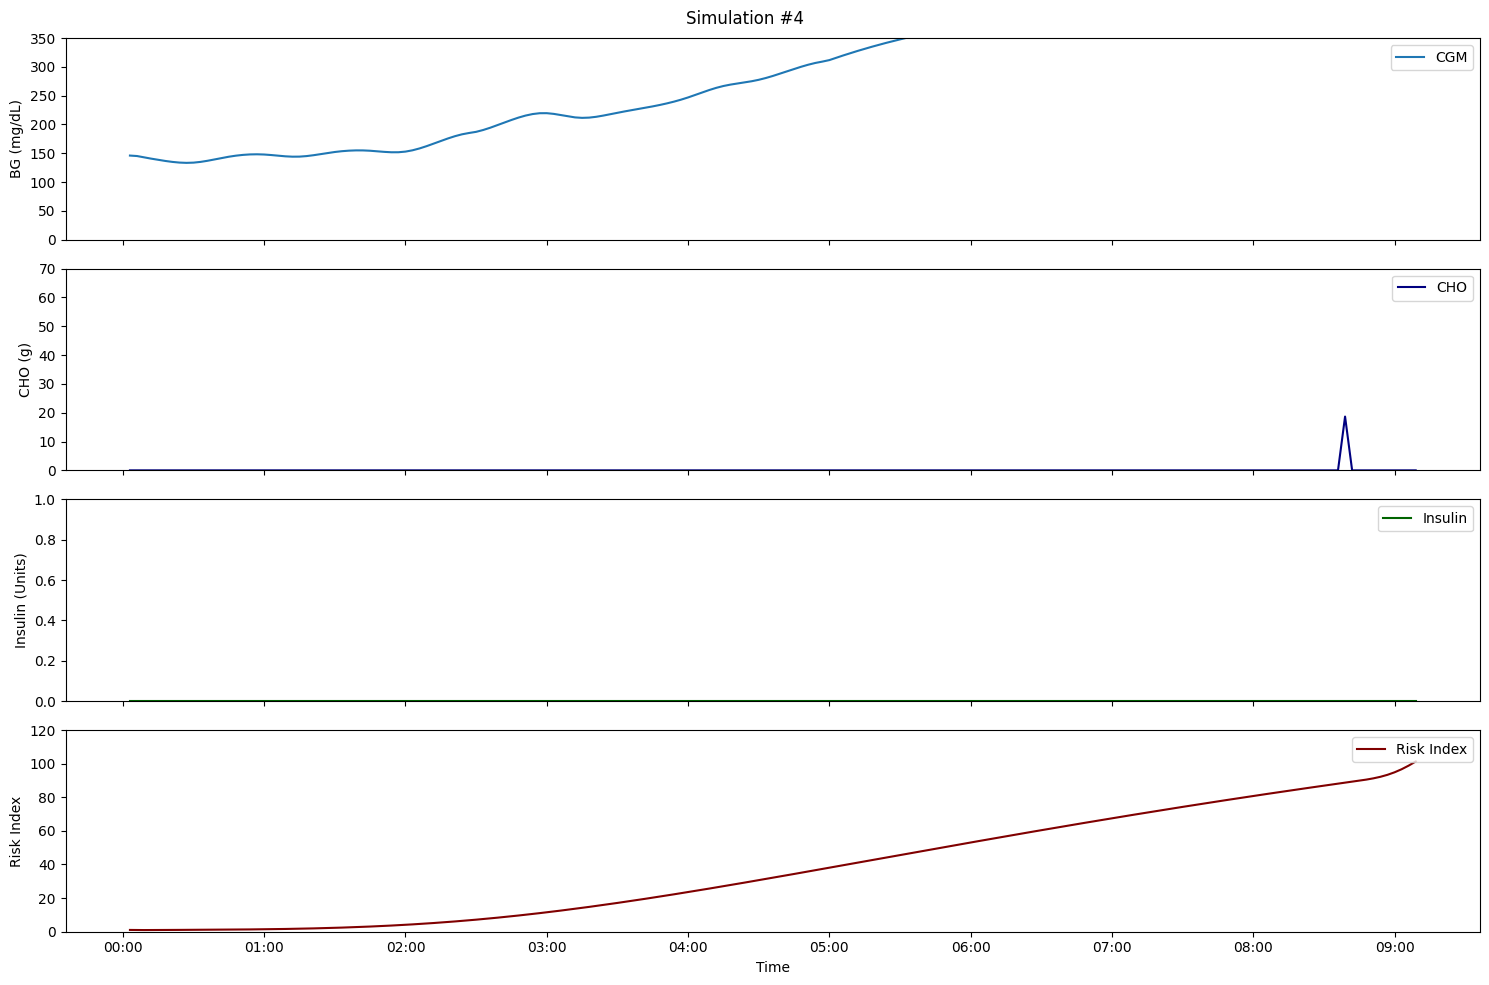

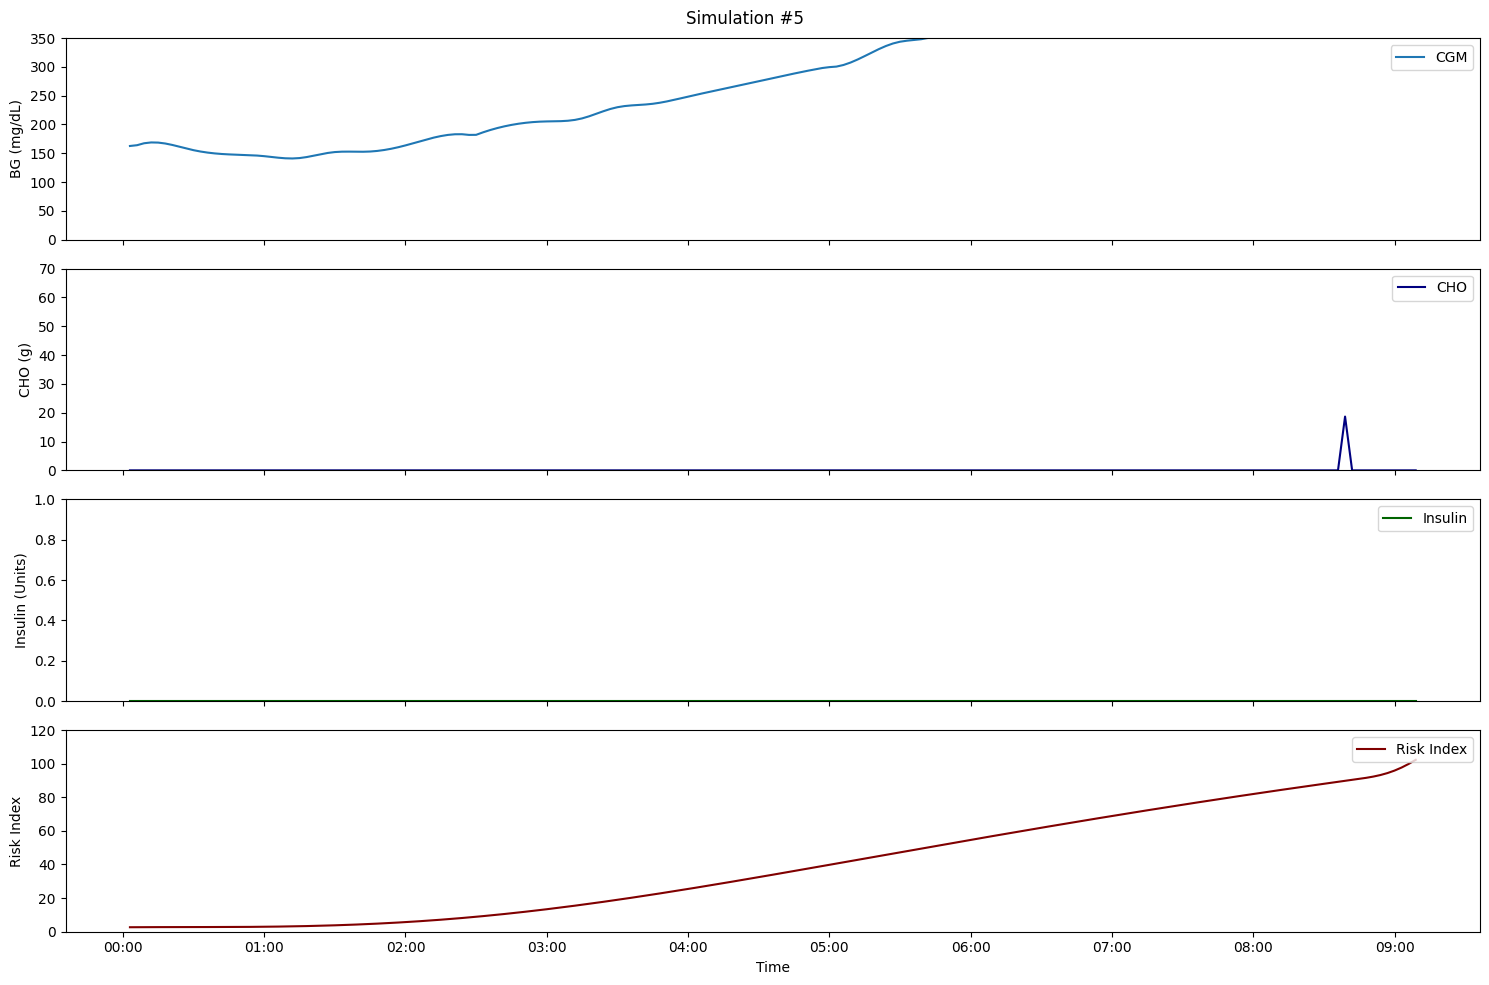

The percentage of time in the 70-180 healthy range is  -96.53551912568307
eval performance of the learned policy: -276.66
survival periods of the each simulated episode: [183, 183, 183, 183, 183]


In [18]:

register(
    id='simglucose-child6-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'child#006',
            'custom_scenario': random_scenario,
            'reward_fun': custom_reward}
)

eval_episodes = 5
env_test = gym.make('simglucose-child6-v0')
score, eval_r, survive = evaluate(actor, env_test, eval_episodes, "child6")
# wandb.run.summary["score"]=score
print("eval performance of the learned policy: {}".format(score))
print("survival periods of the each simulated episode: {}".format(survive))

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


the initial bg_last_hour is  [Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673), Observation(CGM=156.63822198441673)]
survived  214
the last two hour CGM are  [Observation(CGM=385.2928760417978), Observation(CGM=382.69197367386334), Observation(CGM=378.9838242057513), Observation(CGM=375.1896057367306), Observation(CGM=372.35054110300007), Observ

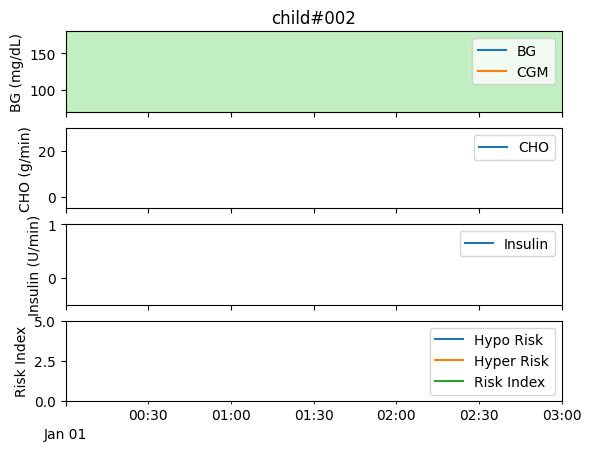

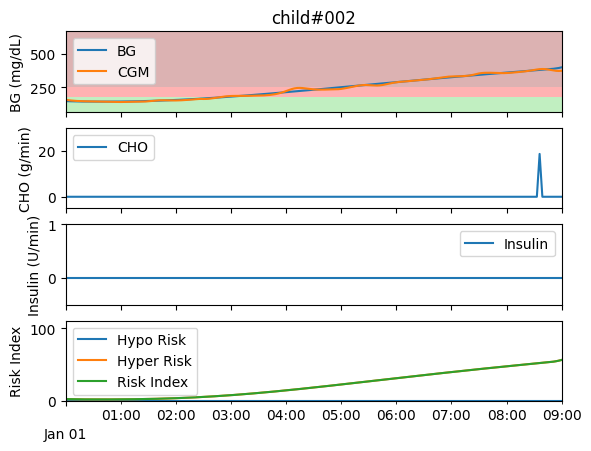

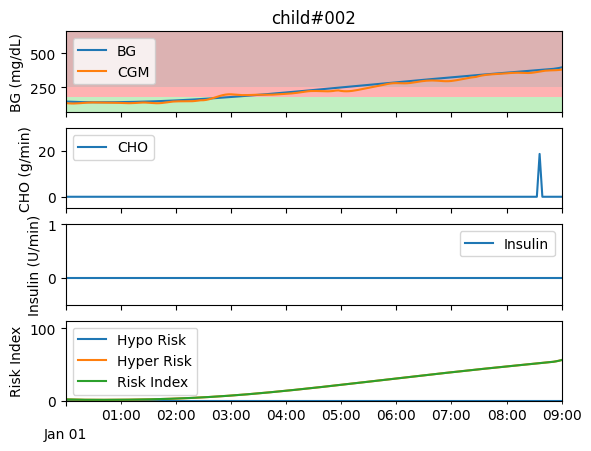

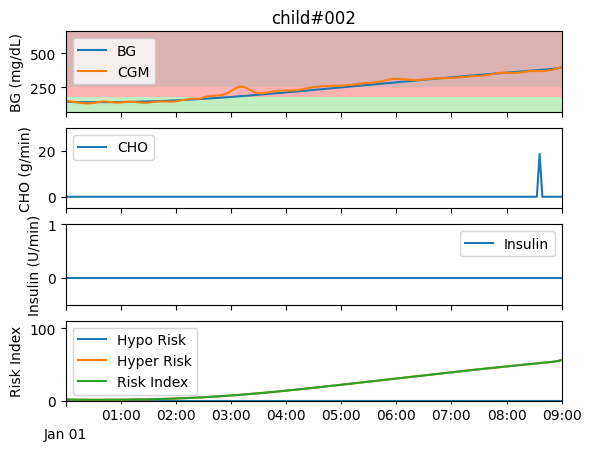

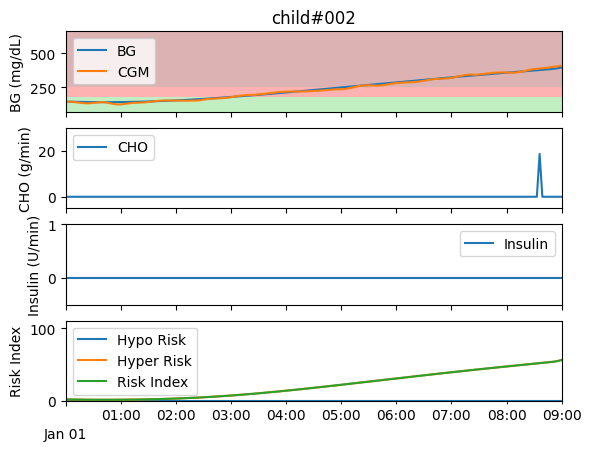

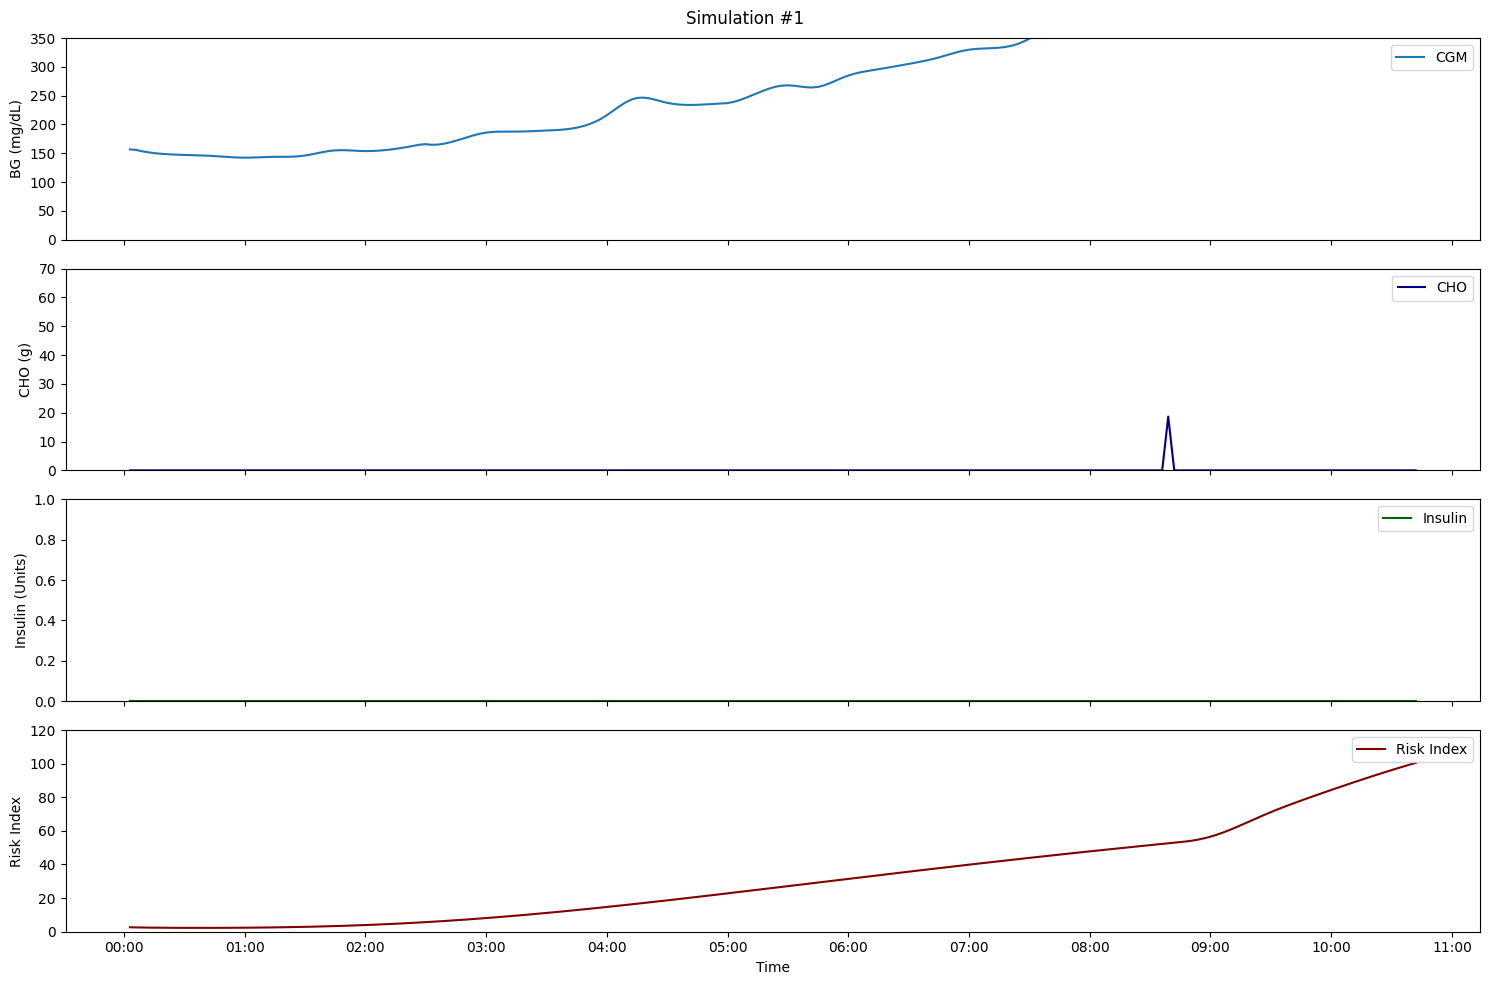

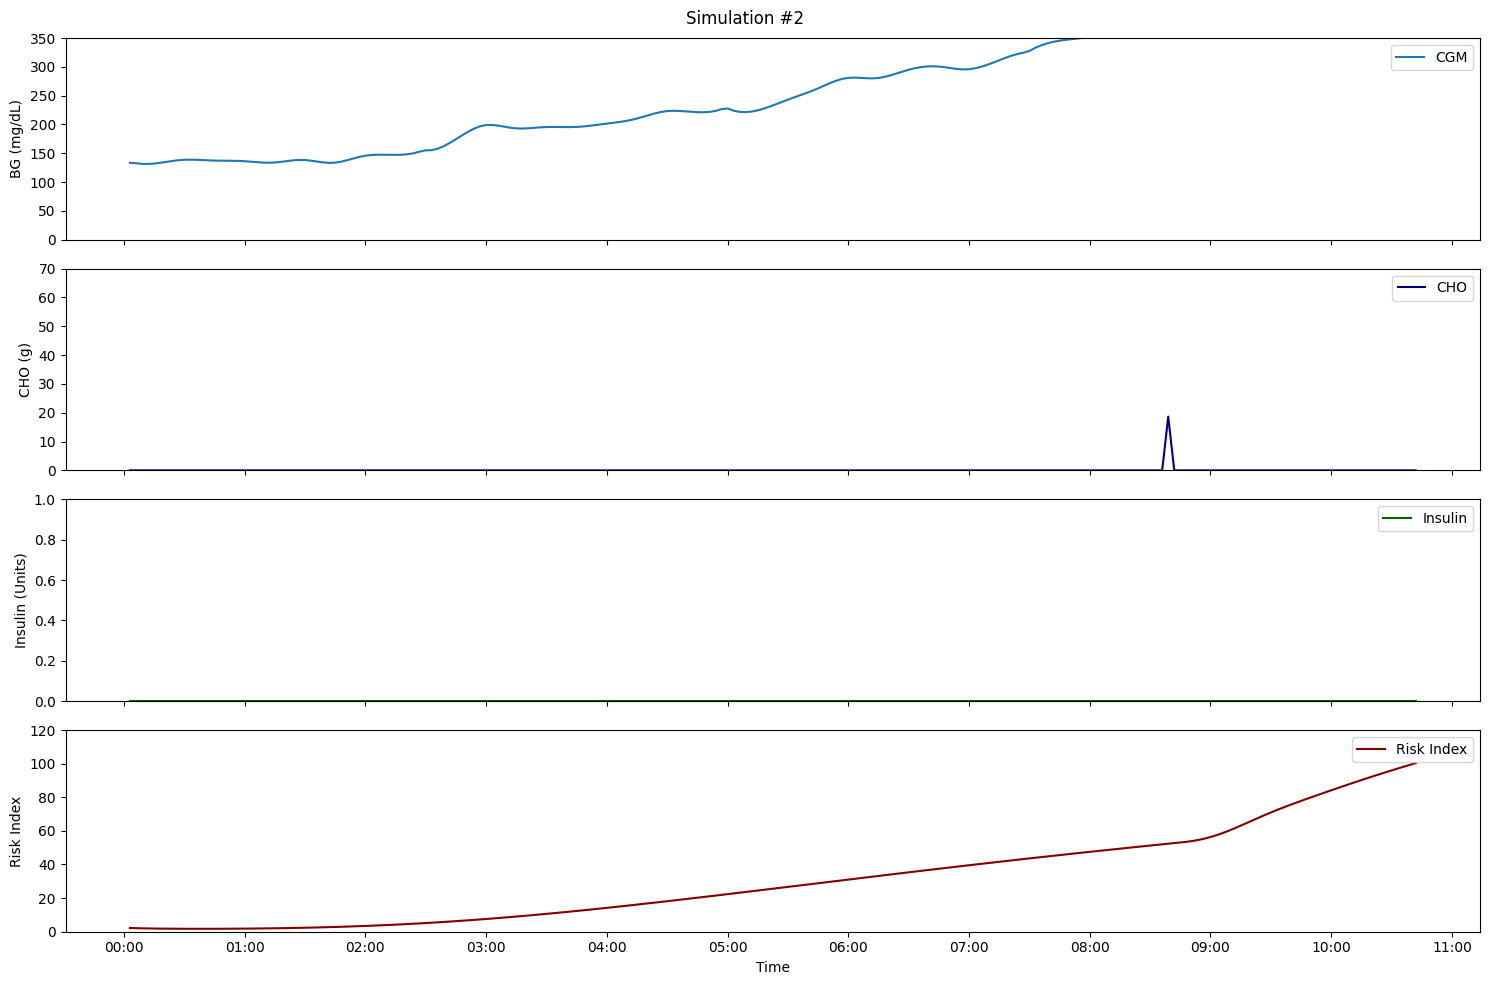

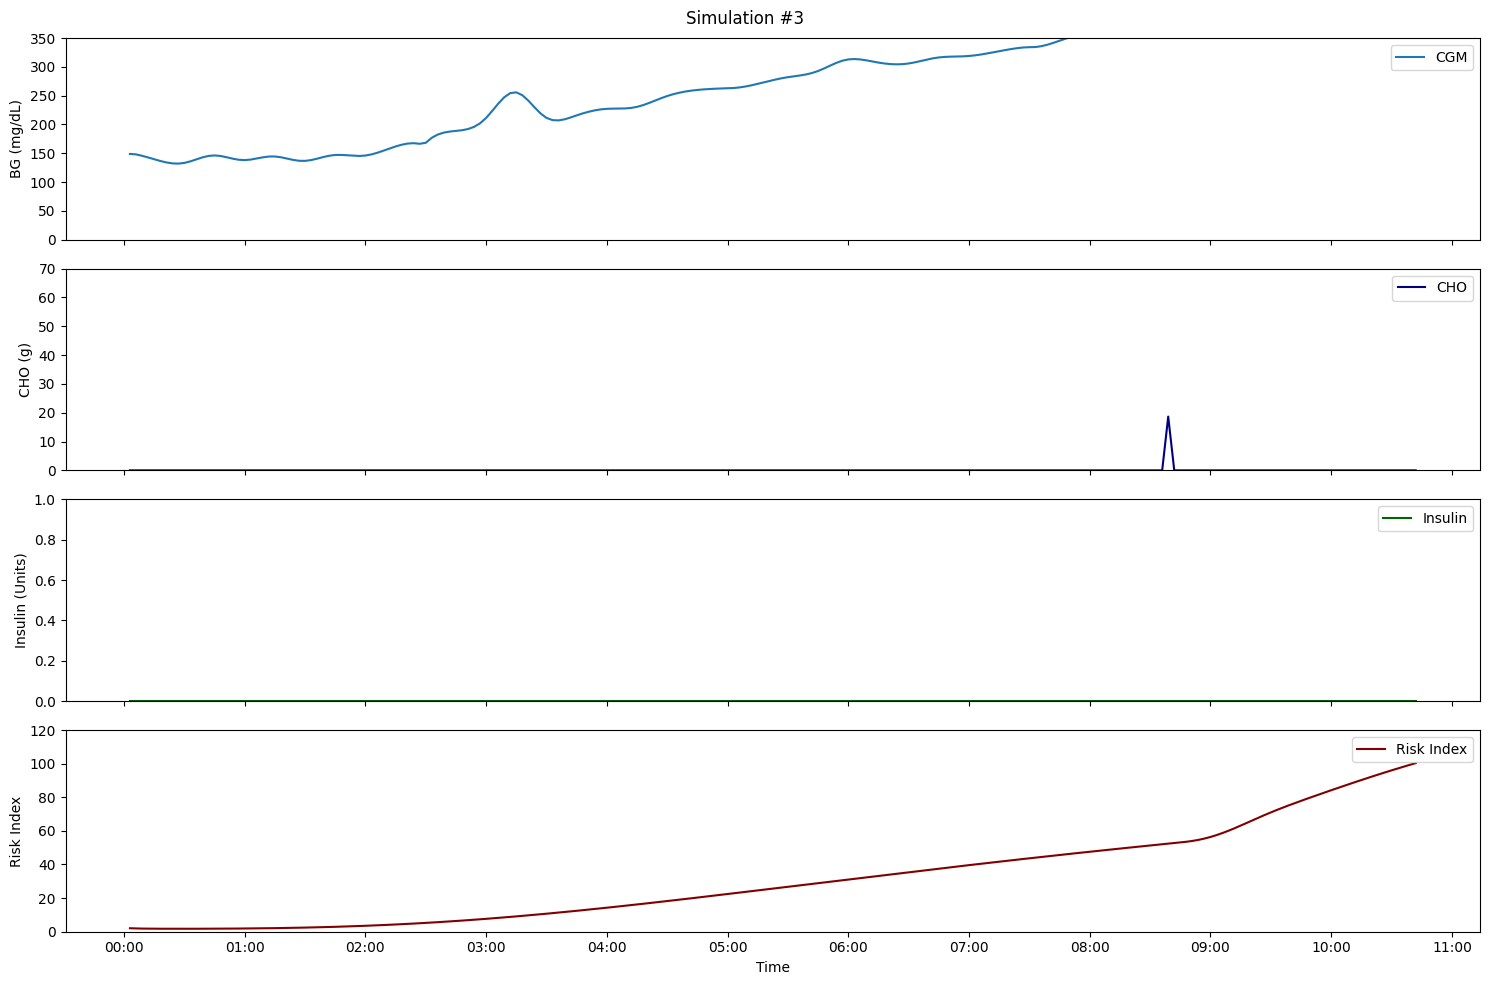

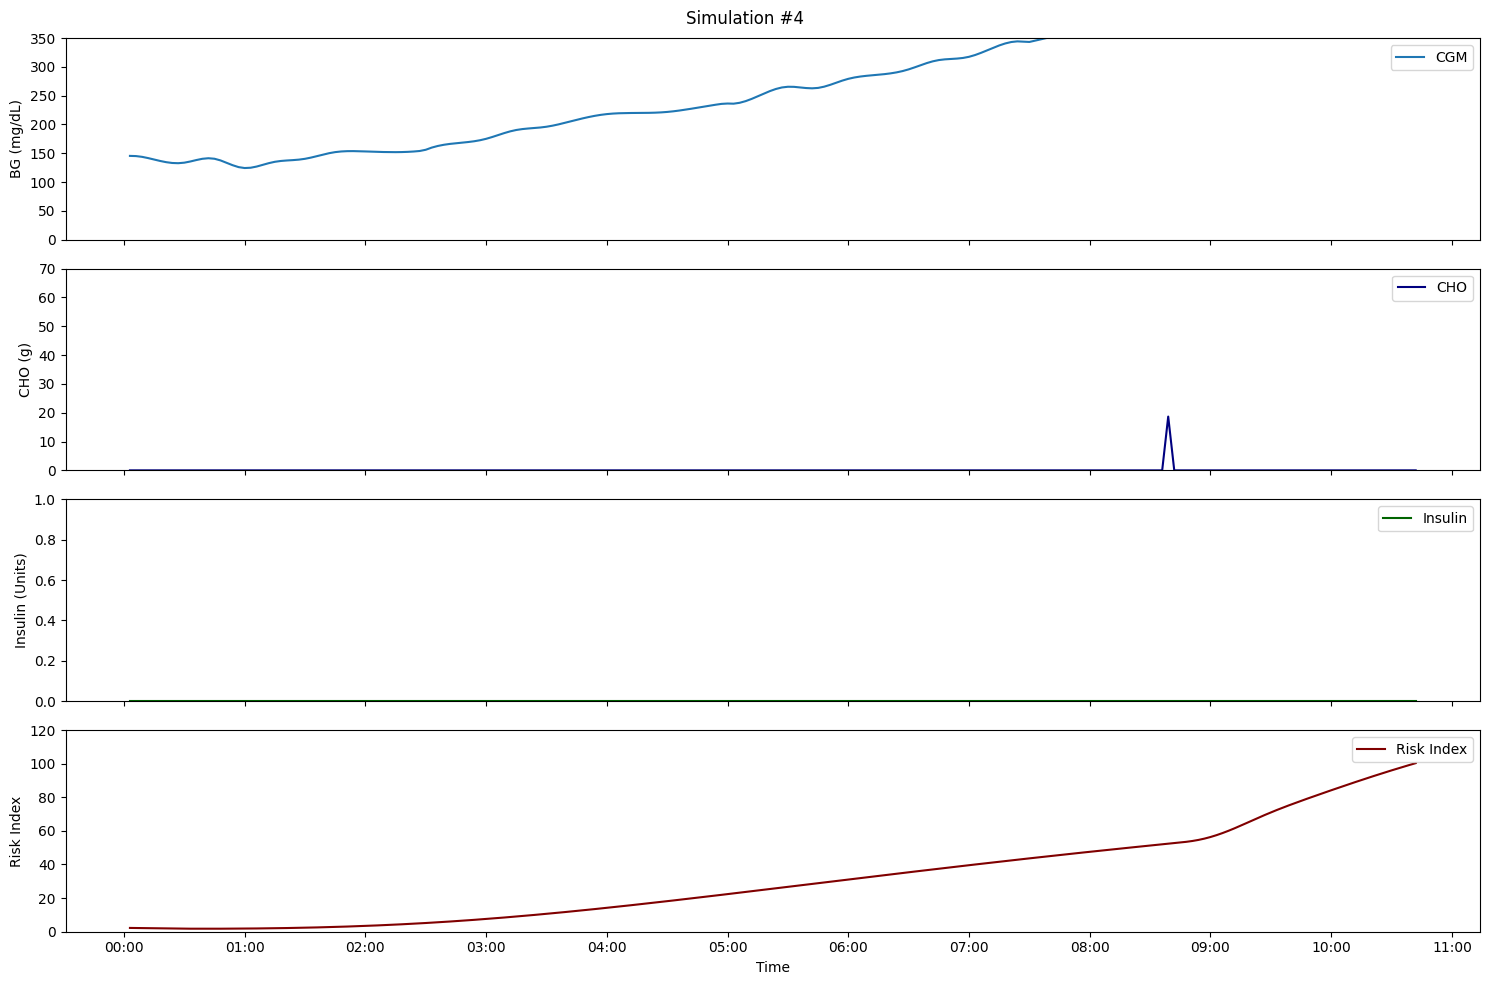

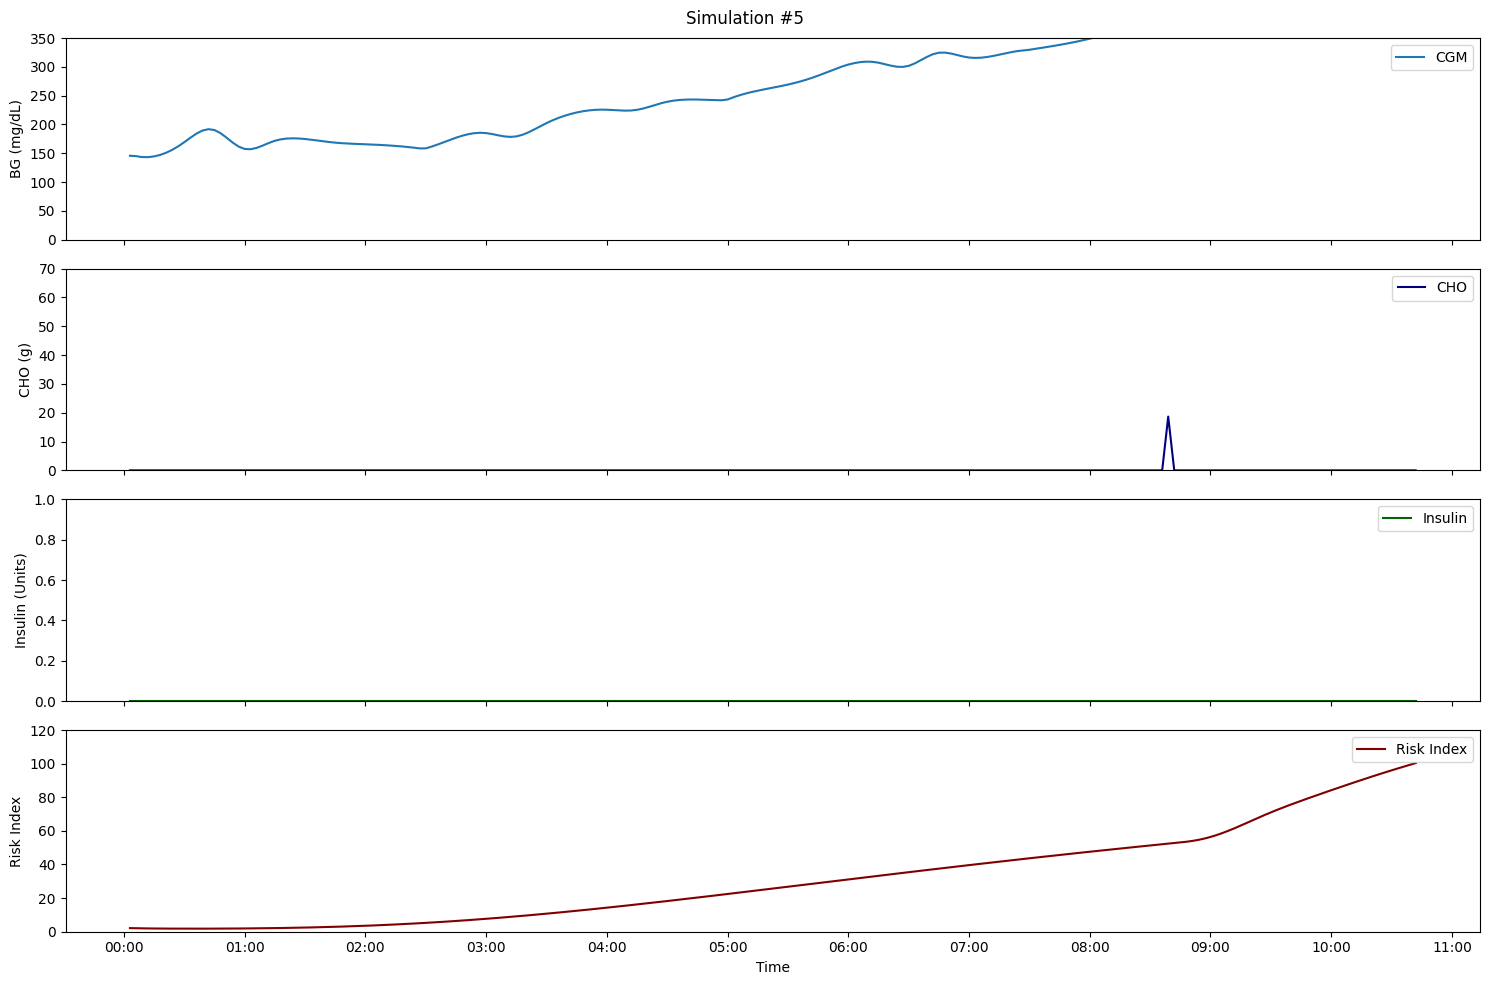

The percentage of time in the 70-180 healthy range is  -83.17757009345794
eval performance of the learned policy: -278.0
survival periods of the each simulated episode: [214, 214, 214, 214, 214]


In [19]:

register(
    id='simglucose-child2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'child#002',
            'custom_scenario': random_scenario,
            'reward_fun': custom_reward}
)

eval_episodes = 5
env_test = gym.make('simglucose-child2-v0')
score, eval_r, survive = evaluate(actor, env_test, eval_episodes, "child2")
# wandb.run.summary["score"]=score
print("eval performance of the learned policy: {}".format(score))
print("survival periods of the each simulated episode: {}".format(survive))

In [19]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(ACTS_np)
# np.set_printoptions()


In [27]:
# import gym

# # Register gym environment. By specifying kwargs,
# # you are able to choose which patient or patients to simulate.
# # patient_name must be 'adolescent#001' to 'adolescent#010',
# # or 'adult#001' to 'adult#010', or 'child#001' to 'child#010'
# # It can also be a list of patient names
# # You can also specify a custom scenario or a list of custom scenarios
# # If you chose a list of patient names or a list of custom scenarios,
# # every time the environment is reset, a random patient and scenario will be
# # chosen from the list

# from gym.envs.registration import register
# from simglucose.simulation.scenario import CustomScenario
# from datetime import datetime

# start_time = datetime(2018, 1, 1, 0, 0, 0)
# meal_scenario = CustomScenario(start_time=start_time, scenario=[(1,20)])


# register(
#     id='simglucose-adolescent2-v0',
#     entry_point='simglucose.envs:T1DSimEnv',
#     kwargs={'patient_name': 'adolescent#002',
#             'custom_scenario': meal_scenario}
# )

# env = gym.make('simglucose-adolescent2-v0')

# observation = env.reset()
# for t in range(100):
#     env.render(mode='human')
#     print(observation)
#     # Action in the gym environment is a scalar
#     # representing the basal insulin, which differs from
#     # the regular controller action outside the gym
#     # environment (a tuple (basal, bolus)).
#     # In the perfect situation, the agent should be able
#     # to control the glucose only through basal instead
#     # of asking patient to take bolus
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)

#     print("action is ", action)
#     print("observation is ", observation)
#     print("reward is ", reward)
#     print("done is ", done)
#     print("info is ", info)

#     if done:
#         print("Episode finished after {} timesteps".format(t + 1))
#         break

### Some basic findings/insghts help understand:

timestep is every three mintues

In [ ]:
if isinstance(env.action_space, gym.spaces.Box):
    print("Action space low:", env.action_space.low)
    print("Action space high:", env.action_space.high)

In [ ]:
# import gym
# from gym.envs.registration import register


# def custom_reward(BG_last_hour):
#     if BG_last_hour[-1] > 180:
#         return -1
#     elif BG_last_hour[-1] < 70:
#         return -2
#     else:
#         return 1


# register(
#     id='simglucose-adolescent2-v0',
#     entry_point='simglucose.envs:T1DSimEnv',
#     kwargs={'patient_name': 'adolescent#002',
#             'reward_fun': custom_reward}
# )

# env = gym.make('simglucose-adolescent2-v0')

# reward = 1
# done = False

# observation = env.reset()
# for t in range(200):
#     env.render(mode='human')
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     print(observation)
#     print("Reward = {}".format(reward))
#     if done:
#         print("Episode finished after {} timesteps".format(t + 1))
#         break